## 0. Pre

In [1]:
# 1. KaggleHub 설치 (처음 한 번만 실행)
!pip install kagglehub
import kagglehub

import os

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTENC

import re

import warnings

import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 다운로드
path = kagglehub.dataset_download("volpatto/coffee-quality-database-from-cqi")
print("Path to dataset files:", path)

# 실제 데이터셋 다운로드 경로 확인
print("Base path:", path)

# 내부 파일/폴더 리스트 출력
print("Files and folders in dataset path:")
print(os.listdir(path))

100%|██████████| 254k/254k [00:00<00:00, 43.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/volpatto/coffee-quality-database-from-cqi/versions/1
Base path: /root/.cache/kagglehub/datasets/volpatto/coffee-quality-database-from-cqi/versions/1
Files and folders in dataset path:
['arabica_data_cleaned.csv', 'merged_data_cleaned.csv', 'robusta_data_cleaned.csv']


In [3]:
df = pd.read_csv(f"{path}/arabica_data_cleaned.csv")
# 미리보기
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [4]:
column_rename_map = {
    "Country.of.Origin": "Country of Origin",
    "Farm.Name": "Farm Name",
    "Lot.Number": "Lot Number",
    "ICO.Number": "ICO Number",
    "Bag.Weight": "Bag Weight",
    "In.Country.Partner": "In-Country Partner",
    "Harvest.Year": "Harvest Year",
    "Grading.Date": "Grading Date",
    "Processing.Method": "Processing Method",
    "Total.Cup.Points": "Total Cup Points",
    "Cupper.Points": "Overall",
    "Clean.Cup": "Clean Cup",
    "Category.One.Defects": "Category One Defects",
    "Category.Two.Defects": "Category Two Defects",
    "Certification.Body": "Certification Body",
    "Certification.Address": "Certification Address",
    "Certification.Contact": "Certification Contact",
    "Owner.1": "Owner"
    # 필요한 경우 더 추가
}

df.rename(columns=column_rename_map, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country of Origin      1310 non-null   object 
 4   Farm Name              955 non-null    object 
 5   Lot Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO Number             1163 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag Weight             1311 non-null   object 
 14  In-Country Partner     1311 non-null   object 
 15  Harv

In [5]:
'''
데이터 출처: Coffee Quality Institute(CQI)
전 세계 커피 품질 햐앙을 위해 설립된 비영리 단체(미국, 1996년 설립)

데이터 내용:
1) 커피의 생산,가공,감각 평가(sensory evaluation)
2) 유전 정보, 토양, 결점(bean defects) 등 다양한 품질 요소 포함

데이터
1, 감각평가(sensory evaluation) - 커피 맛 관련 10개 지표
Aroma	커피의 향 (후각적 인상)
Flavor	커피 맛 전반 (단맛, 쓴맛, 산미 등)
Aftertaste	마신 후 입 안에 남는 여운
Acidity	밝기, 상큼함을 느끼게 하는 맛의 요소
Body	커피의 점도(질감), 입안에서 느껴지는 무게감
Balance	맛 요소들의 균형감
Uniformity	한 샘플 내 여러 잔의 일관성
Clean Cup	결점 없는 깔끔한 맛
Sweetness	캐러멜, 과일, 꽃향기 등 긍정적인 단맛
Overall	평가자의 종합적인 인상

2. 결점(defects) - 커피 품질에 부정적 영향을 주는 요소
Category One Defects	시각적으로 확인 가능한 주요 결점 (예: 검은 콩, 곰팡이 손상 등)
Category Two Defects	미각으로 감지되는 부차적 결점 (예: 오래된 맛, 발효 과다 등)
Defects	결점 총점 (상기 두 항목에서 계산됨)

3. 기타 컬럼
Country of Origin	원산지 국가
Variety	커피 품종 (예: Bourbon, Caturra 등)
Processing Method	가공 방식 (예: Washed, Natural 등)
Altitude	재배 고도
Color	로스팅 전 원두의 색상
Moisture Percentage	원두 내 수분 비율
Number of Bags / Bag Weight	샘플 물량
Grading Date / Harvest Year	수확 연도 및 평가 날짜

4. 타켓 변수
Total Cup Points: 위의 10가지 점수를 모두 더한 값 (정확한 계산 공식이 알려져 있음)
'''

'\n데이터 출처: Coffee Quality Institute(CQI)\n전 세계 커피 품질 햐앙을 위해 설립된 비영리 단체(미국, 1996년 설립)\n\n데이터 내용:\n1) 커피의 생산,가공,감각 평가(sensory evaluation)\n2) 유전 정보, 토양, 결점(bean defects) 등 다양한 품질 요소 포함\n\n데이터\n1, 감각평가(sensory evaluation) - 커피 맛 관련 10개 지표\nAroma\t커피의 향 (후각적 인상)\nFlavor\t커피 맛 전반 (단맛, 쓴맛, 산미 등)\nAftertaste\t마신 후 입 안에 남는 여운\nAcidity\t밝기, 상큼함을 느끼게 하는 맛의 요소\nBody\t커피의 점도(질감), 입안에서 느껴지는 무게감\nBalance\t맛 요소들의 균형감\nUniformity\t한 샘플 내 여러 잔의 일관성\nClean Cup\t결점 없는 깔끔한 맛\nSweetness\t캐러멜, 과일, 꽃향기 등 긍정적인 단맛\nOverall\t평가자의 종합적인 인상\n\n2. 결점(defects) - 커피 품질에 부정적 영향을 주는 요소\nCategory One Defects\t시각적으로 확인 가능한 주요 결점 (예: 검은 콩, 곰팡이 손상 등)\nCategory Two Defects\t미각으로 감지되는 부차적 결점 (예: 오래된 맛, 발효 과다 등)\nDefects\t결점 총점 (상기 두 항목에서 계산됨)\n\n3. 기타 컬럼\nCountry of Origin\t원산지 국가\nVariety\t커피 품종 (예: Bourbon, Caturra 등)\nProcessing Method\t가공 방식 (예: Washed, Natural 등)\nAltitude\t재배 고도\nColor\t로스팅 전 원두의 색상\nMoisture Percentage\t원두 내 수분 비율\nNumber of Bags / Bag Weight\t샘플 물량\nGrading Date / Harvest Year\t수확 연도 및 평가 날짜\n\n4. 타켓

## 1. Data Preparation
- 1. Data Cleaning: 이상치, 결측치 제거 or 보간
- 2. Data Transformation: 문자열 -> 숫자 등 형식 변환
- 3. Data Reduction: 불필요한 컬럼 제거
- 4. Feature Engineering: 파생 변수 생성, 인코딩

In [6]:
# 범주형 컬럼, 수치형 컬럼 자동 분류
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("범주형(Categorical) 변수:", categorical_cols)
print("수치형(Numerical) 변수:", numerical_cols)

범주형(Categorical) 변수: ['Species', 'Owner', 'Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'ICO Number', 'Company', 'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner', 'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Processing Method', 'Color', 'Expiration', 'Certification Body', 'Certification Address', 'Certification Contact', 'unit_of_measurement']
수치형(Numerical) 변수: ['Unnamed: 0', 'Number.of.Bags', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Overall', 'Total Cup Points', 'Moisture', 'Category One Defects', 'Quakers', 'Category Two Defects', 'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']


In [7]:
#수치형 결측치 처리
#결점(bean defect)의 수이므로, 결측 = 결점이 없음으로 간주하고 0 대체
df["Quakers"] = df["Quakers"].fillna(0)

In [8]:
# 문자형 결측치는 'Unknown'으로 채움
fill_unknown_cols = ["Country of Origin", 'Color','Variety', 'Processing Method', 'Mill', 'Farm Name', 'Region', 'Producer']
df[fill_unknown_cols] = df[fill_unknown_cols].fillna("Unknown")

In [9]:
# 중복된 샘플이 있으면 머신러닝 모델 학습에 편향(bias) 생길 수 있음 -> 삭제
duplicate_rows = df[df.duplicated()]
print("중복 row의 수 ", duplicate_rows.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

중복 row의 수  (0, 44)
(1311, 44)


In [10]:
# altitude
# altitude_mean_meters → 최우선 사용, 부족한 경우 low/high로 평균 계산하여 대체
df["Altitude"] = df["altitude_mean_meters"]
missing_alt = df["Altitude"].isna()
df.loc[missing_alt, "Altitude"] = (
    df.loc[missing_alt, ["altitude_low_meters", "altitude_high_meters"]]
    .mean(axis=1)
)

# Altitude 수치형 변환
def clean_altitude(alt):
    if isinstance(alt, str):
        alt = alt.strip().replace(" ", "")
        if '-' in alt:
            try:
                start, end = alt.split('-')
                return (int(start) + int(end)) / 2
            except:
                return np.nan
        try:
            return float(alt)
        except:
            return np.nan
    return alt

still_missing = df["Altitude"].isna()
df.loc[still_missing, "Altitude"] = (
    df.loc[still_missing, "Altitude"].combine_first(
        df.loc[still_missing, "Altitude"].apply(clean_altitude)
    )
)

# 마지막 결측은 전체 중앙값으로 대체
df["Altitude"] = df["Altitude"].fillna(df["Altitude"].median())

print(df["Altitude"].value_counts().head(20))


df["Altitude"] = df["Altitude"].apply(clean_altitude)
df["Altitude"] = df["Altitude"].fillna(df["Altitude"].median())
print(df["Altitude"].dtype)

Altitude
1310.64    258
1200.00     66
1400.00     52
1100.00     52
1300.00     50
1500.00     44
1250.00     39
1700.00     36
1600.00     35
1550.00     34
1750.00     34
1800.00     33
1450.00     33
1775.00     33
1000.00     32
1219.20     28
1350.00     25
1650.00     22
800.00      18
1850.00     12
Name: count, dtype: int64
float64


In [11]:
# Bag Weight
print(df["Bag Weight"].unique()[:20])

def extract_weight(kg_string):
    if isinstance(kg_string, str):
        # 숫자만 추출
        number = ''.join(c for c in kg_string if c.isdigit())
        try:
            return int(number)
        except:
            return np.nan
    return kg_string  # 이미 숫자인 경우

df["Bag Weight"] = df["Bag Weight"].apply(extract_weight)
print(df["Bag Weight"].dtype)

['60 kg' '1' '30 kg' '69 kg' '1 kg' '2 kg,lbs' '6' '3 lbs' '50 kg' '2 lbs'
 '100 lbs' '15 kg' '2 kg' '2' '70 kg' '19200 kg' '5 lbs' '1 kg,lbs' '6 kg'
 '0 lbs']
int64


In [12]:
# Harvest Year
import pandas as pd
import re
from dateutil import parser

# 함수 정의
def extract_year(value):
    if pd.isnull(value):
        return None

    # 문자열에서 4자리 연도 패턴 추출
    match = re.search(r"(20\d{2}|19\d{2})", str(value))
    if match:
        return int(match.group(0))
    else:
        return None

# 연도 추출
df["Harvest Year"] = df["Harvest Year"].apply(extract_year)

# datetime 형식으로 변환
df["Harvest Year"] = pd.to_datetime(df["Harvest Year"], format="%Y", errors="coerce")

# 최빈값 대체
mode_year = df["Harvest Year"].mode()[0]
df["Harvest Year"] = df["Harvest Year"].fillna(mode_year)

# 2. 다시 datetime 변환
df["Harvest Year"] = pd.to_datetime(df["Harvest Year"], format="%Y", errors="coerce")

# 3. Expiration도 datetime 변환
df["Expiration"] = df["Expiration"].apply(parser.parse)

# 4. Coffee Age 파생변수 다시 생성
df["Coffee Age"] = (df["Expiration"] - df["Harvest Year"]).dt.days

# Coffee Age 생성 이후 여전히 남은 결측치 → 중앙값 대체
df["Coffee Age"] = df["Coffee Age"].fillna(df["Coffee Age"].median())
df["Coffee Age"] = df["Coffee Age"].fillna(0).astype(int)

df.drop(columns=["Harvest Year", "Expiration"], inplace=True, errors='ignore')

In [13]:
#불필요한 컬럼 제거
# 의미 없는 식별자 컬럼 제거
df.drop(columns=["ICO Number", "Lot Number"], inplace=True)

# 상관 낮은 변수 제거
drop_low_corr = [
    "Uniformity", "Clean Cup", "Sweetness",
    "Moisture Percentage", "Category One Defects"
]
df.drop(columns=drop_low_corr, inplace=True, errors='ignore')

# 12. 의미 없는 범주형 변수 제거
manual_drops = [
    "Status", "Certification Address", "Certification Contact",
    "Owner", "Company", "Farm Name", "Producer"
]
df.drop(columns=manual_drops, inplace=True, errors='ignore')

# 새로 만든 컬럼으로 대체한 기존 컬럼 삭제
df.drop(columns=[
    "altitude_low_meters",
    "altitude_high_meters",
    "altitude_mean_meters",
    "Unnamed: 0",
    "unit_of_measurement",
    "Species",
    "Moisture"
], inplace=True, errors='ignore')

In [14]:
# 결측치 개수 확인
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts

,0


In [15]:
df.isnull().sum().sum()  # == 0일 것!

# 최종 확인
print(df.shape)

(1311, 23)


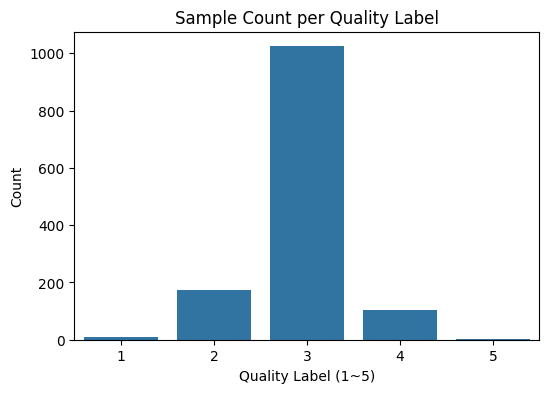

Quality_Label
1    0.006102
2    0.131960
3    0.781083
4    0.080092
5    0.000763
Name: proportion, dtype: float64


In [16]:
# Classification 문제로 바꾸기 : Quality_label 생성
# label 만들기
def quality_label(score):
    if score >= 90:
        return 5  # Outstanding
    elif score >= 85:
        return 4  # Excellent
    elif score >= 80:
        return 3  # Very Good
    elif score >= 70:
        return 2  # Acceptable
    else:
        return 1  # Poor

#적용
df['Quality_Label'] = df['Total Cup Points'].apply(quality_label)

# 라벨 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x="Quality_Label", data=df)
# 품질 등급별 샘플 수
plt.title("Sample Count per Quality Label")
plt.xlabel("Quality Label (1~5)")
plt.ylabel("Count")
plt.show()

# 비율도 같이 보기
print(df["Quality_Label"].value_counts(normalize=True).sort_index())


In [17]:
# 'Quality_Label'을 만들 때 사용한 수치형 타겟은 이제 불필요
df.drop(columns=["Total Cup Points"], inplace=True)

## 2. Encoding

In [18]:
# 1. 타겟과 입력 분리
y = df["Quality_Label"]
X = df.drop(columns=["Quality_Label"])

# 2. 범주형 컬럼 찾기
categorical_cols = X.select_dtypes(include="object").columns.tolist()
print("Categorical columns:", categorical_cols)

# 3. 원핫인코딩
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("최종 X shape:", X_encoded.shape)
print("타겟 y 예시:", y.head())

Categorical columns: ['Country of Origin', 'Mill', 'Region', 'In-Country Partner', 'Grading Date', 'Variety', 'Processing Method', 'Color', 'Certification Body']
최종 X shape: (1311, 1484)
타겟 y 예시: 0    5
1    4
2    4
3    4
4    4
Name: Quality_Label, dtype: int64


In [19]:
!pip install imbalanced-learn
# # SMOTE 적용
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_encoded, y = smote.fit_resample(X_encoded, y)
# print("After SMOTE:", y.value_counts().sort_index())

# 6. SMOTENC 적용
from imblearn.over_sampling import SMOTENC
# 샘플이 너무 적은 클래스 제거 (ex: 5개 미만)
vc = y.value_counts()
drop_labels = vc[vc < 6].index.tolist()

mask = ~y.isin(drop_labels)
X_filtered = X_encoded[mask]
y_filtered = y[mask]

# 다시 SMOTENC
from imblearn.over_sampling import SMOTENC

# 범주형 인덱스 자동 추출
cat_indices = [i for i, col in enumerate(X_filtered.columns) if any(cat in col for cat in categorical_cols)]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
X_encoded, y = smote_nc.fit_resample(X_filtered, y_filtered)


print("SMOTENC 완료 후 라벨 분포:")
print(pd.Series(y).value_counts())

SMOTENC 완료 후 라벨 분포:
Quality_Label
4    1024
3    1024
2    1024
1    1024
Name: count, dtype: int64


In [20]:
# 컬럼명 전처리 (특수문자 제거 + 중복 방지)
# 1. 컬럼명 전처리: 특수문자 제거 + 중복 방지
import re

def clean_column_name(col):
    col = re.sub(r'[^A-Za-z0-9_]', '_', col)   # 특수문자 → _
    col = re.sub(r'_+', '_', col)              # 연속된 _ → 하나로
    col = col.strip('_')                       # 앞뒤 _ 제거
    return col

X_encoded.columns = [clean_column_name(col) for col in X_encoded.columns]

def make_column_names_unique(columns):
    seen = {}
    new_cols = []
    for col in columns:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}__{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    return new_cols

# 특수문자 제거
X_encoded.columns = [clean_column_name(col) for col in X_encoded.columns]

# 중복 방지
X_encoded.columns = make_column_names_unique(X_encoded.columns)

## 4. Model

In [21]:
# 기존 Quality_Label이 1~5라면 → 0~4로 변환
y = y - 1

import warnings
warnings.filterwarnings("ignore")

# 1. 기본 모듈
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 모델 리스트
models = {
    "RandomForest": RandomForestClassifier(random_state=42),  #제일 좋은 성능
    # "XGBoost": XGBClassifier(random_state=42, verbosity=0),
    # "GradientBoosting": GradientBoostingClassifier(random_state=42),
    # "LightGBM": LGBMClassifier(random_state=42)
}

# 스코어 함수들
scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "F1 (macro)": make_scorer(f1_score, average='macro'),
    "Precision (macro)": make_scorer(precision_score, average='macro'),
    "Recall (macro)": make_scorer(recall_score, average='macro'),
}

# 결과 저장
results = {}  # 결과 저장용 딕셔너리

# 결과 저장 및 출력
for name, model in models.items():
    print(f"\n {name}")
    results[name] = {}
    for metric_name, scorer in scorers.items():
        try:
            score = cross_val_score(model, X_encoded, y, cv=5, scoring=scorer)
            mean_score = score.mean()
            results[name][metric_name] = mean_score
            print(f"{metric_name}: {mean_score:.4f}")
        except Exception as e:
            print(f"{metric_name} 실패: {e}")
    print("-" * 50)


 RandomForest
Accuracy: 0.9548
F1 (macro): 0.9541
Precision (macro): 0.9618
Recall (macro): 0.9549
--------------------------------------------------


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 파라미터 후보 정의
param_grid = {
    "n_estimators": [100, 200],          # 트리 개수
    "max_depth": [None, 10, 20],         # 트리 최대 깊이
    "min_samples_split": [2, 5],         # 내부 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [1, 2],          # 리프 노드가 되기 위한 최소 샘플 수
    "max_features": ["sqrt", "log2"]     # 각 분할에서 고려할 최대 피처 수
}

# 모델 정의
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",  # F1-score 기준으로 평가
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_encoded, y)

# 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9547542742197168


In [23]:
import pandas as pd

# 결과 딕셔너리를 데이터프레임으로 변환
results_df = pd.DataFrame(results).T  # 모델 이름이 index로, 지표가 column으로
results_df = results_df.round(4)
display(results_df)

,Accuracy,F1 (macro),Precision (macro),Recall (macro)
RandomForest,0.9548,0.9541,0.9618,0.9549


<Figure size 600x500 with 0 Axes>

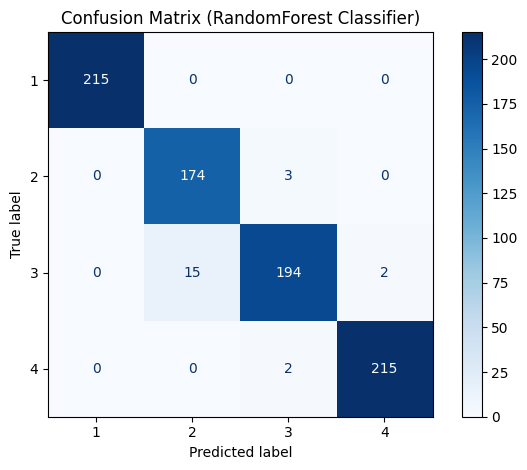

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 예측 대상 라벨 다시 1~5로
y_adjusted = y + 1

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_adjusted, test_size=0.2, random_state=42)

# 모델 학습 및 예측
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred)

# 유니크한 라벨 자동 추출
labels = sorted(list(set(y_test) | set(y_pred)))

# 시각화
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (RandomForest Classifier)")
plt.tight_layout()
plt.show()

## requirements.txt

In [25]:
import numpy
import pandas
import matplotlib
import seaborn
import xgboost
import sklearn
import lightgbm
import kagglehub
import imblearn

versions = {
    "numpy": numpy.__version__,
    "pandas": pandas.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": seaborn.__version__,
    "xgboost": xgboost.__version__,
    "scikit-learn": sklearn.__version__,
    "lightgbm": lightgbm.__version__,
    "kagglehub": kagglehub.__version__,
    "imbalanced-learn": imblearn.__version__,
}

with open("requirements.txt", "w") as f:
    for pkg, ver in versions.items():
        f.write(f"{pkg}=={ver}\n")

print("✅ requirements.txt 파일 생성 완료")

✅ requirements.txt 파일 생성 완료
